In [95]:
import chromadb

client = chromadb.HttpClient(host="localhost", port=9000)

# Test connection
client.heartbeat()

1750566325793935407

In [96]:
chroma_collection_cleaned_document = client.get_collection("MBKM_Informatika_minimal")
chroma_collection_without_cleaned_document = client.get_collection("MBKM_Informatika_without_cleaning")

In [97]:
from sentence_transformers import SentenceTransformer
import pandas as pd

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict
from nltk.tokenize import word_tokenize

In [98]:
from typing import Tuple


class RAGComparator:
    def __init__(self, collection_cleaned, collection_raw, sentence_model):
        self.collection_cleaned = collection_cleaned
        self.collection_raw = collection_raw
        self.sentence_model = sentence_model

    def retrieve_documents(self, collection, query: str, n_results: int = 5) -> Dict:
        """Retrieve documents from specified collection"""
        results = collection.query(
            query_texts=[query],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )
        return results

    def calculate_context_precision(self, query: str, retrieved_docs: List[str], ground_truth: str) -> float:
        """Calculate Context Precision"""
        if not retrieved_docs:
            return 0.0

        query_embedding = self.sentence_model.encode([query])
        gt_embedding = self.sentence_model.encode([ground_truth])

        relevant_count = 0
        total_docs = len(retrieved_docs)

        for doc in retrieved_docs:
            doc_embedding = self.sentence_model.encode([doc])
            query_sim = cosine_similarity(query_embedding, doc_embedding)[0][0]
            gt_sim = cosine_similarity(gt_embedding, doc_embedding)[0][0]
            combined_sim = (query_sim + gt_sim) / 2

            if combined_sim > 0.3:
                relevant_count += 1

        return relevant_count / total_docs

    def calculate_faithfulness(self, answer: str, retrieved_docs: List[str]) -> float:
        """Calculate Faithfulness"""
        if not answer or not retrieved_docs:
            return 0.0

        combined_context = " ".join(retrieved_docs)

        # Keyword overlap
        answer_tokens = set(word_tokenize(answer.lower()))
        context_tokens = set(word_tokenize(combined_context.lower()))

        stopwords = {'dan', 'atau', 'yang', 'di', 'ke', 'dari', 'untuk', 'dengan', 'pada', 'dalam', 'adalah', 'ini',
                     'itu', 'jika', 'akan', 'dapat', 'bisa', 'sudah', 'telah', 'harus', 'wajib'}
        answer_tokens = answer_tokens - stopwords
        context_tokens = context_tokens - stopwords

        answer_tokens = {token for token in answer_tokens if token.isalnum()}
        context_tokens = {token for token in context_tokens if token.isalnum()}

        if not answer_tokens:
            return 0.0

        overlap = len(answer_tokens.intersection(context_tokens))
        keyword_faithfulness = overlap / len(answer_tokens)

        # Semantic similarity
        answer_embedding = self.sentence_model.encode([answer])
        context_embedding = self.sentence_model.encode([combined_context])
        semantic_faithfulness = cosine_similarity(answer_embedding, context_embedding)[0][0]

        faithfulness = (keyword_faithfulness + semantic_faithfulness) / 2
        return max(0.0, min(1.0, faithfulness))

    def calculate_answer_relevancy(self, query: str, answer: str) -> float:
        """Calculate Answer Relevancy"""
        if not query or not answer:
            return 0.0

        query_embedding = self.sentence_model.encode([query])
        answer_embedding = self.sentence_model.encode([answer])

        relevancy = cosine_similarity(query_embedding, answer_embedding)[0][0]
        return max(0.0, min(1.0, relevancy))

    def evaluate_collection(self, collection, collection_name: str, dataset: List[Dict], n_results: int = 5) -> List[
        Dict]:
        """Evaluate a specific collection"""
        results = []

        print(f"\nEvaluating {collection_name}...")

        for i, data in enumerate(dataset):
            query = data['question']
            ground_truth = data['ground_truth']

            # Retrieve documents
            retrieval_results = self.retrieve_documents(collection, query, n_results)
            retrieved_docs = retrieval_results['documents'][0] if retrieval_results['documents'] else []
            distances = retrieval_results['distances'][0] if retrieval_results['distances'] else []

            # Use first document as answer
            answer = retrieved_docs[0] if retrieved_docs else ""

            # Calculate metrics
            context_precision = self.calculate_context_precision(query, retrieved_docs, ground_truth)
            faithfulness = self.calculate_faithfulness(answer, retrieved_docs)
            answer_relevancy = self.calculate_answer_relevancy(query, answer)

            result = {
                'collection': collection_name,
                'question_id': i,
                'question': query,
                'ground_truth': ground_truth,
                'answer': answer,
                'context_precision': round(context_precision, 4),
                'faithfulness': round(faithfulness, 4),
                'answer_relevancy': round(answer_relevancy, 4),
                'num_retrieved': len(retrieved_docs),
                'avg_distance': round(np.mean(distances), 4) if distances else 0.0
            }

            results.append(result)

            print(f"  Q{i + 1}: CP={context_precision:.3f}, F={faithfulness:.3f}, AR={answer_relevancy:.3f}")

        return results

    def compare_collections(self, dataset: List[Dict], n_results: int = 5) -> Tuple[pd.DataFrame, Dict]:
        """Compare both collections"""

        # Evaluate cleaned collection
        cleaned_results = self.evaluate_collection(
            self.collection_cleaned, "Cleaned Documents", dataset, n_results
        )

        # Evaluate raw collection
        raw_results = self.evaluate_collection(
            self.collection_raw, "Raw Documents", dataset, n_results
        )

        # Combine results
        all_results = cleaned_results + raw_results
        df_comparison = pd.DataFrame(all_results)

        # Calculate summary statistics
        summary_stats = {}
        for collection_name in ["Cleaned Documents", "Raw Documents"]:
            collection_data = df_comparison[df_comparison['collection'] == collection_name]
            summary_stats[collection_name] = {
                'context_precision': collection_data['context_precision'].mean(),
                'faithfulness': collection_data['faithfulness'].mean(),
                'answer_relevancy': collection_data['answer_relevancy'].mean(),
                'avg_distance': collection_data['avg_distance'].mean(),
                'num_retrieved': collection_data['num_retrieved'].mean()
            }

        return df_comparison, summary_stats

In [99]:
# Initialize sentence transformer untuk semantic similarity
sentence_model = SentenceTransformer('all-mpnet-base-v2')
print("Sentence transformer model loaded")

Sentence transformer model loaded


In [100]:
comparator = RAGComparator(chroma_collection_cleaned_document, chroma_collection_without_cleaned_document,
                           sentence_model)


In [101]:
evaluation_dataset = [
    {
        "question": "Apa perbedaan antara program magang MBKM dan non-MBKM?	",
        "ground_truth": "Program MBKM adalah program dari Kementerian Pendidikan yang harus dikonversikan ke SKS Mata Kuliah dan memerlukan surat PKS, sementara program magang non-MBKM adalah program magang yang dikonversikan ke SKEM atau untuk menambah pengalaman dan tidak memerlukan surat PKS."
    },
    {
        "question": "Apa syarat minimal SKS yang harus sudah ditempuh mahasiswa untuk mengikuti program magang MBKM?",
        "ground_truth": "Mahasiswa minimal harus sudah lulus 90 SKS atau sudah lulus semester 5 untuk mengikuti program magang MBKM."
    },
    {
        "question": "Apa tugas PK2 dalam mengelola pendaftaran program magang di ITS?",
        "ground_truth": "PK2 mengkoordinir pendaftaran program magang melalui SIM Magang, melakukan seleksi administrasi, mengecek track record magang mahasiswa, dan mengirimkan data kandidat peserta magang ke mitra."
    },
    {
        "question": "Apa saja peran mitra magang dalam program magang ITS?	",
        "ground_truth": "Peran mitra magang meliputi memberikan profil perusahaan, menyusun perjanjian kerja sama magang, memberikan tugas dan arahan kepada mahasiswa magang, serta menyediakan fasilitas kerja dan penilaian prestasi mahasiswa."
    },
    {
        "question": "Bagaimana penilaian prestasi mahasiswa dilakukan oleh mitra magang?",
        "ground_truth": "Mitra magang memberikan penilaian berdasarkan formulir penilaian yang meliputi aspek-aspek seperti inisiatif, kemampuan komunikasi, disiplin, penampilan, ketekunan, kemampuan teknikal, berpikir kritis, kemampuan bekerjasama, kemampuan beradaptasi, dan hasil pekerjaan (kontribusi), yang kemudian diserahkan ke departemen untuk verifikasi."
    },
    {
        "question": "Apa itu SIM Magang dan apa fungsinya?",
        "ground_truth": "SIM Magang adalah sistem informasi yang digunakan untuk mengelola pendaftaran, pelaksanaan, dan pelaporan program magang. Fungsinya termasuk mengunggah berkas magang, pengecekan data, serta monitoring kegiatan magang mahasiswa."
    }
]

In [102]:
print("=== RAG COLLECTION COMPARISON ===")
df_comparison, summary_stats = comparator.compare_collections(evaluation_dataset)

=== RAG COLLECTION COMPARISON ===

Evaluating Cleaned Documents...
  Q1: CP=1.000, F=0.988, AR=0.615
  Q2: CP=1.000, F=0.992, AR=0.653
  Q3: CP=1.000, F=0.999, AR=0.704
  Q4: CP=1.000, F=0.992, AR=0.657
  Q5: CP=1.000, F=0.949, AR=0.636
  Q6: CP=1.000, F=0.919, AR=0.483

Evaluating Raw Documents...
  Q1: CP=1.000, F=0.998, AR=0.690
  Q2: CP=1.000, F=0.995, AR=0.759
  Q3: CP=1.000, F=1.000, AR=0.693
  Q4: CP=1.000, F=0.998, AR=0.676
  Q5: CP=1.000, F=0.992, AR=0.551
  Q6: CP=1.000, F=0.992, AR=0.508


In [103]:
print("\n=== SUMMARY STATISTICS ===")
summary_df = pd.DataFrame(summary_stats).T
print(summary_df.round(4))



=== SUMMARY STATISTICS ===
                   context_precision  faithfulness  answer_relevancy  \
Cleaned Documents                1.0        0.9730            0.6247   
Raw Documents                    1.0        0.9956            0.6463   

                   avg_distance  num_retrieved  
Cleaned Documents        0.8036            5.0  
Raw Documents            0.7842            5.0  


In [104]:
# Calculate improvement percentages
cleaned_stats = summary_stats["Cleaned Documents"]
raw_stats = summary_stats["Raw Documents"]

In [105]:
improvements = {}

for metric in ['context_precision', 'faithfulness', 'answer_relevancy']:
    improvement = ((cleaned_stats[metric] - raw_stats[metric]) / raw_stats[metric]) * 100
    improvements[metric] = improvement

print("\n=== IMPROVEMENTS (Cleaned vs Raw) ===")
for metric, improvement in improvements.items():
    print(f"{metric.replace('_', ' ').title()}: {improvement:+.2f}%")


=== IMPROVEMENTS (Cleaned vs Raw) ===
Context Precision: +0.00%
Faithfulness: -2.28%
Answer Relevancy: -3.34%


In [106]:
# Simpan hasil ke file CSV
df_results.to_csv('rag_evaluation_results.csv', index=False)
print(f"\nResults saved to 'rag_evaluation_results.csv'")


Results saved to 'rag_evaluation_results.csv'


/tmp/ipykernel_3385208/251302839.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Cleaned', 'Raw'], patch_artist=True)
/tmp/ipykernel_3385208/251302839.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Cleaned', 'Raw'], patch_artist=True)
/tmp/ipykernel_3385208/251302839.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Cleaned', 'Raw'], patch_artist=True)


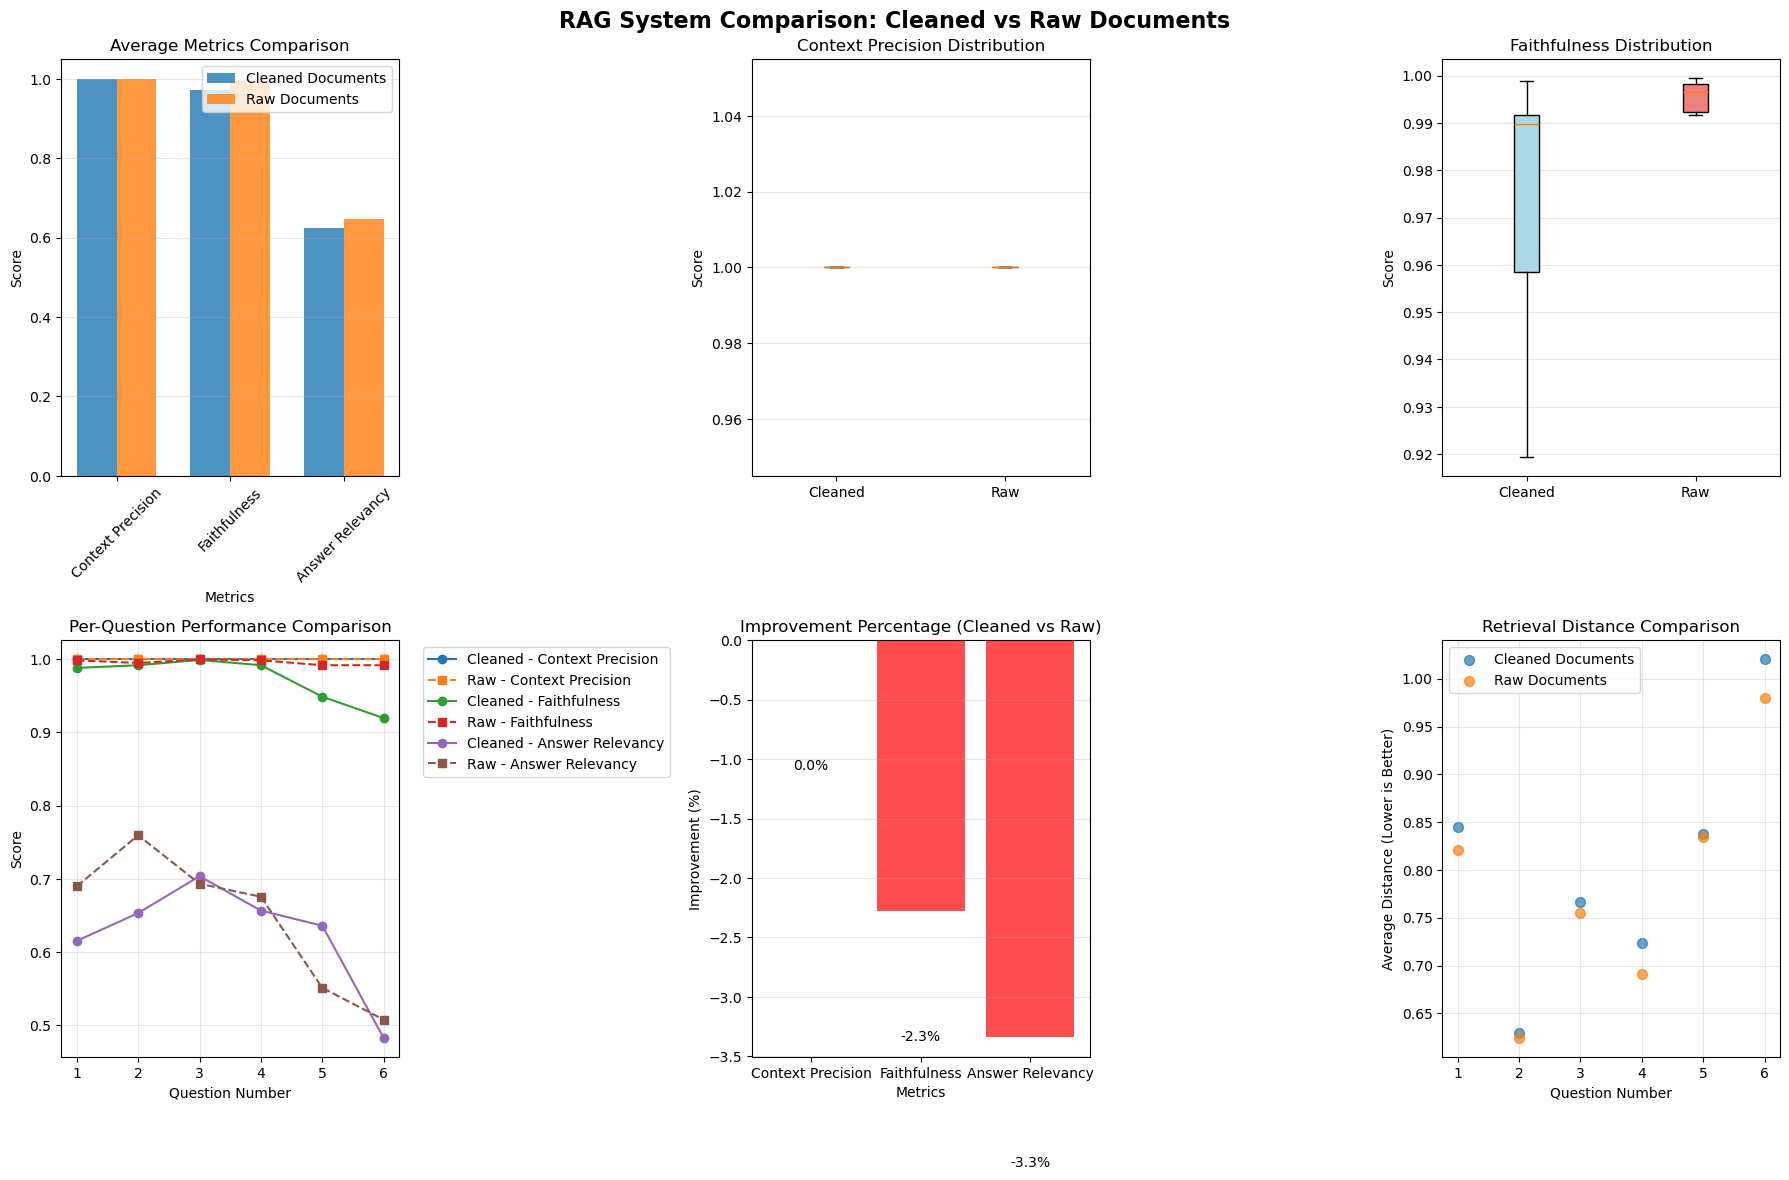

In [107]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RAG System Comparison: Cleaned vs Raw Documents', fontsize=16, fontweight='bold')
# 1. Bar chart comparison of average metrics
metrics = ['context_precision', 'faithfulness', 'answer_relevancy']
metric_labels = ['Context Precision', 'Faithfulness', 'Answer Relevancy']

cleaned_values = [cleaned_stats[metric] for metric in metrics]
raw_values = [raw_stats[metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width / 2, cleaned_values, width, label='Cleaned Documents', alpha=0.8)
axes[0, 0].bar(x + width / 2, raw_values, width, label='Raw Documents', alpha=0.8)
axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Average Metrics Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metric_labels, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Box plot for each metric
for i, metric in enumerate(metrics):
    row = (i + 1) // 3
    col = (i + 1) % 3

    data_to_plot = [
        df_comparison[df_comparison['collection'] == 'Cleaned Documents'][metric].values,
        df_comparison[df_comparison['collection'] == 'Raw Documents'][metric].values
    ]

    box_plot = axes[row, col].boxplot(data_to_plot, labels=['Cleaned', 'Raw'], patch_artist=True)
    axes[row, col].set_title(f'{metric_labels[i]} Distribution')
    axes[row, col].set_ylabel('Score')
    axes[row, col].grid(axis='y', alpha=0.3)

    # Color the boxes
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

# 3. Line plot for per-question comparison
axes[1, 0].clear()
questions = range(1, len(evaluation_dataset) + 1)

for metric in metrics:
    cleaned_metric = df_comparison[df_comparison['collection'] == 'Cleaned Documents'][metric].values
    raw_metric = df_comparison[df_comparison['collection'] == 'Raw Documents'][metric].values

    axes[1, 0].plot(questions, cleaned_metric, marker='o', label=f'Cleaned - {metric_labels[metrics.index(metric)]}',
                    linestyle='-')
    axes[1, 0].plot(questions, raw_metric, marker='s', label=f'Raw - {metric_labels[metrics.index(metric)]}',
                    linestyle='--')

axes[1, 0].set_xlabel('Question Number')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Per-Question Performance Comparison')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(alpha=0.3)

# 4. Improvement percentage bar chart
axes[1, 1].clear()
improvement_values = [improvements[metric] for metric in metrics]
colors = ['green' if x > 0 else 'red' for x in improvement_values]

bars = axes[1, 1].bar(metric_labels, improvement_values, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Improvement (%)')
axes[1, 1].set_title('Improvement Percentage (Cleaned vs Raw)')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, improvement_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2., height + (1 if height > 0 else -1),
                    f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

# 5. Distance comparison
axes[1, 2].clear()
cleaned_distances = df_comparison[df_comparison['collection'] == 'Cleaned Documents']['avg_distance'].values
raw_distances = df_comparison[df_comparison['collection'] == 'Raw Documents']['avg_distance'].values

axes[1, 2].scatter(questions, cleaned_distances, label='Cleaned Documents', alpha=0.7, s=50)
axes[1, 2].scatter(questions, raw_distances, label='Raw Documents', alpha=0.7, s=50)
axes[1, 2].set_xlabel('Question Number')
axes[1, 2].set_ylabel('Average Distance (Lower is Better)')
axes[1, 2].set_title('Retrieval Distance Comparison')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [108]:
# save figure
fig.savefig('rag_comparison_results.png', bbox_inches='tight')

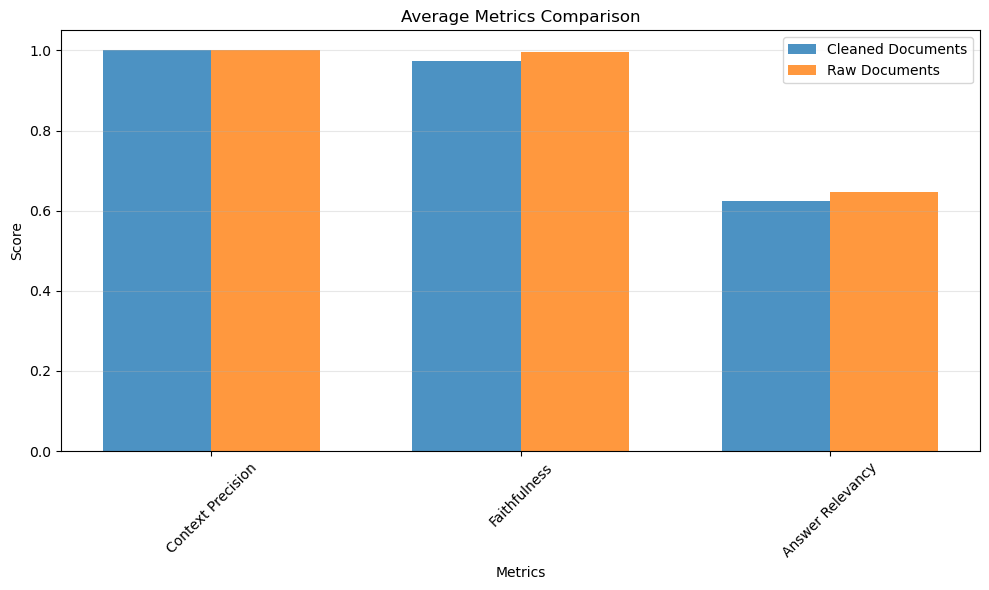

In [109]:
# Saya hanya ingin Average Metrics Comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width / 2, cleaned_values, width, label='Cleaned Documents', alpha=0.8)
ax.bar(x + width / 2, raw_values, width, label='Raw Documents', alpha=0.8)
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Average Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('average_metrics_comparison.png', bbox_inches='tight')
plt.show()
